In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests
import json
import re
import geopy.geocoders as gc
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
tqdm.pandas()

# ZBA Decision Dataset Analysis

In [43]:
data_loaded = False
try:
    decisions_with_demos = pd.read_csv('data/decisions_with_demographics.csv')
    data_loaded = True
except:
    data_loaded = False

In [44]:
# Function to convert the Lat and Long into a census tract.
# Refer to https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html for the FIPS code to census tract conversion
# FCC Census block conversion API link: https://geo.fcc.gov/api/census/#!/block/get_block_find

def Coord_to_census_tract(Lat,Long):
    Converter = requests.get("https://geo.fcc.gov/api/census/block/find?latitude=%20" + str(Lat) + "&longitude=" + str(Long) + "&showall=true&format=json")
    #print(Converter.text)
    Census_data = Converter.text
    json_data = json.loads(Census_data)
    # print(json_data)
    FIPS_code = json_data['Block']['FIPS']
    if FIPS_code is None:
        return "nan"
    Census_tract = FIPS_code[5:11]
    #print(type(Census_tract))
    if Census_tract[0] == "0":
        Census_tract.replace(Census_tract[0],'')
        Census_split = Census_tract[ : 4] + '.'+ Census_tract[4 : ]
        return(Census_split)
    else:
        Census_split = Census_tract[ : 4] + '.'+ Census_tract[4 : ]
        return(Census_split)

In [45]:
def formatAddress(row):
    addr = row['Address']
    addr = addr.split(",")
    return addr[0].strip() + ", Boston, MA"

def generate_decisions_with_demos():
    # load the original data sets
    decisions_data = pd.read_csv("data/Filtered_ZBA_decisions.csv")
    meetings_data = pd.read_csv("data/Filtered_ZBA_meetings.csv")

    # preprocess datasets
    decisions_data['Case Number'] = decisions_data.apply(lambda row: re.sub("[^0-9]", "", row['Case Number']), axis=1)
    meetings_data = meetings_data[meetings_data['Case Number'].notna()]
    meetings_data['Case Number'] = meetings_data.apply(lambda row: re.sub("[^0-9]", "", row['Case Number']), axis=1)

    # merge the decisions dataset with the meeting minutes dataset
    meetings_with_decisions = pd.merge(meetings_data, decisions_data, left_on="Case Number", right_on="Case Number")
    meetings_with_decisions = meetings_with_decisions.drop(columns=['Applicant Address_x', 'Source_x', 'Source_y'])
    meetings_with_decisions = meetings_with_decisions.rename(columns={'Applicant Address_y': 'Address'})

    # format the addresses for geocoding
    meetings_with_decisions['Address'] = meetings_with_decisions.progress_apply(formatAddress, axis=1)

    # perform geocoding to get long and lat of each project address
    gc.options.default_timeout = 10
    geolocator = gc.Nominatim(user_agent="Baystate_Banner_Boston_Building_Binvestigators")
    meetings_with_decisions['geocodes'] = meetings_with_decisions['Address'].progress_apply(geolocator.geocode)
    filtered_meetings_with_decisions = meetings_with_decisions[meetings_with_decisions['geocodes'].notna()]
    filtered_meetings_with_decisions['lat'] = filtered_meetings_with_decisions.progress_apply(lambda row: row['geocodes'].latitude, axis=1)
    filtered_meetings_with_decisions['long'] = filtered_meetings_with_decisions.progress_apply(lambda row: row['geocodes'].longitude, axis=1)

    # load and preprocess neighborhoods dataset
    sub_neigh = pd.read_csv("data/Sub-Neighborhoods.csv")
    sub_neigh['Census Tract#'] = sub_neigh.progress_apply(lambda row: float(row['Census Tract#']), axis=1)
    sub_neigh['White Proportion'] = sub_neigh.progress_apply(lambda row: float(row['White Proportion'][:-1]), axis=1)

    filtered_meetings_with_decisions['Cencus Tract'] = filtered_meetings_with_decisions.progress_apply(lambda row: float(Coord_to_census_tract(row.lat, row.long)), axis=1)
    filtered_meetings_with_decisions = filtered_meetings_with_decisions[filtered_meetings_with_decisions['Cencus Tract'].notna()]
    decisions_with_demos = pd.merge(filtered_meetings_with_decisions, sub_neigh, left_on="Cencus Tract", right_on="Census Tract#")
    decisions_with_demos = decisions_with_demos.drop(columns=['Unnamed: 0', 'Census Tract#'])

    # write the data out to a csv file
    decisions_with_demos.to_csv('data/decisions_with_demographics.csv')

    return decisions_with_demos

In [46]:
if not data_loaded:
    decisions_with_demos = generate_decisions_with_demos()

## Analysis & Visualization

In [47]:
pdf = PdfPages('charts.out.pdf')
chart_num = 0

Plot decision approval/denials in majority white and non-white areas

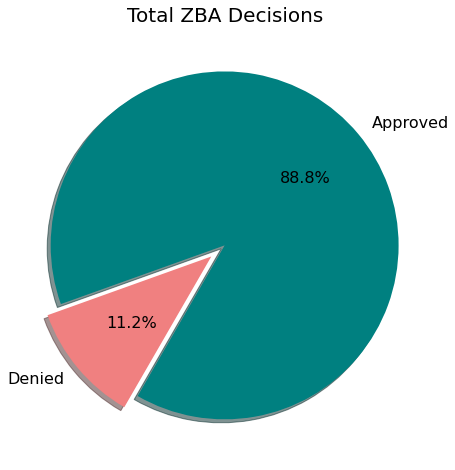

In [48]:
num_approved = len(decisions_with_demos[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'])
num_denied = len(decisions_with_demos[decisions_with_demos['Decision (Approve/Reject)'] == 'Denied'])

plt.figure(figsize=[8,8])
plt.title("Total ZBA Decisions", fontdict={'fontsize': 20})
plt.pie([num_approved, num_denied], (0, 0.1), startangle=-120, shadow=True, autopct="%1.1f%%", labels=['Approved', 'Denied'], colors=['teal', 'lightcoral'], textprops={'fontsize': 16})

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()


In [49]:
grouped_neighs = decisions_with_demos.groupby('Neighborhood')
grouped_neighs_stats = grouped_neighs.agg(["size", np.mean])['White Proportion']
grouped_neighs_approved = decisions_with_demos[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'].groupby('Neighborhood')
grouped_neighs_approved_size = grouped_neighs_approved.agg(["size", np.mean])['White Proportion']
grouped_neighs_approved_size['Real Mean'] = grouped_neighs_stats['mean']
grouped_neighs_approved_size = grouped_neighs_approved_size.sort_values('Real Mean', ascending=False)['size']
grouped_neighs_stats = grouped_neighs_stats.sort_values('mean', ascending=False)

grouped_neighs_maj_white = grouped_neighs_stats[grouped_neighs_stats['mean'] >= 50.0]
grouped_neighs_maj_nonwhite = grouped_neighs_stats[grouped_neighs_stats['mean'] < 50.0]
grouped_neighs_maj_white_approved = grouped_neighs_approved_size[grouped_neighs_stats['mean'] >= 50.0]
grouped_neighs_maj_nonwhite_approved = grouped_neighs_approved_size[grouped_neighs_stats['mean'] < 50.0]
grouped_neighs_maj_nonwhite

,size,mean
Neighborhood,,
Dorchester,455,49.675385
Hyde Park,80,40.174375
Roxbury,166,24.906024
Mattapan,34,11.425294


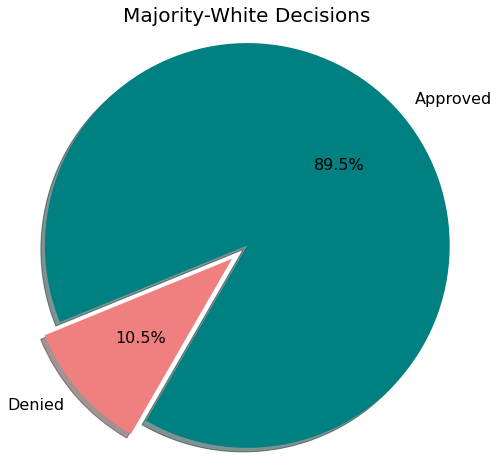

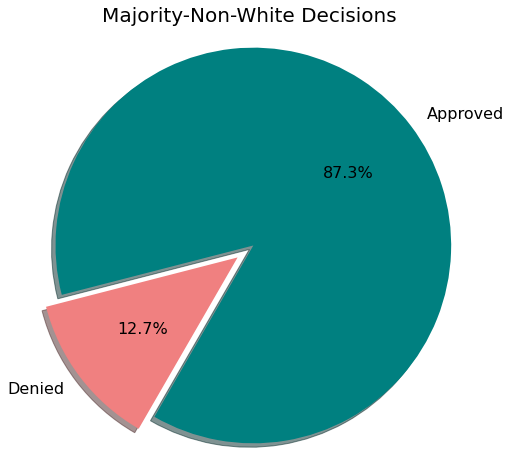

In [50]:
total_decisions = sum(grouped_neighs_maj_white['size'].values)
total_approvals = sum(grouped_neighs_maj_white_approved.values)
total_denials = total_decisions - total_approvals

plt.figure(figsize=[8,8])
plt.title("Majority-White Decisions", fontdict={'fontsize': 20})
plt.pie([total_approvals, total_denials], (0, 0.1), startangle=-120, shadow=True, autopct="%1.1f%%", labels=['Approved', 'Denied'], colors=['teal', 'lightcoral'], textprops={'fontsize': 16})
plt.axis('equal')

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

total_decisions = sum(grouped_neighs_maj_nonwhite['size'].values)
total_approvals = sum(grouped_neighs_maj_nonwhite_approved.values)
total_denials = total_decisions - total_approvals

plt.figure(figsize=[8,8])
plt.title("Majority-Non-White Decisions", fontdict={'fontsize': 20})
plt.pie([total_approvals, total_denials], (0, 0.1), startangle=-120, shadow=True, autopct="%1.1f%%", labels=['Approved', 'Denied'], colors=['teal', 'lightcoral'], textprops={'fontsize': 16})
plt.axis('equal')

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

Group by census tract and display zba decisions with denied vs approved sorted by white percentage

In [51]:
grouped_ct = decisions_with_demos.groupby('Cencus Tract')
grouped_ct_stats = grouped_ct.agg(["size", np.mean])['White Proportion']
grouped_ct_approved = decisions_with_demos[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'].groupby('Cencus Tract')
grouped_ct_approved_size = grouped_ct_approved.agg(["size", np.mean])['White Proportion']
grouped_ct_approved_size['Real Mean'] = grouped_ct_stats['mean']
grouped_ct_approved_size = grouped_ct_approved_size.sort_values('Real Mean', ascending=False)['size']
grouped_ct_stats = grouped_ct_stats.sort_values('mean', ascending=False)
grouped_ct_stats = grouped_ct_stats[[x in grouped_ct_approved_size.index.values for x in grouped_ct_stats.index]]

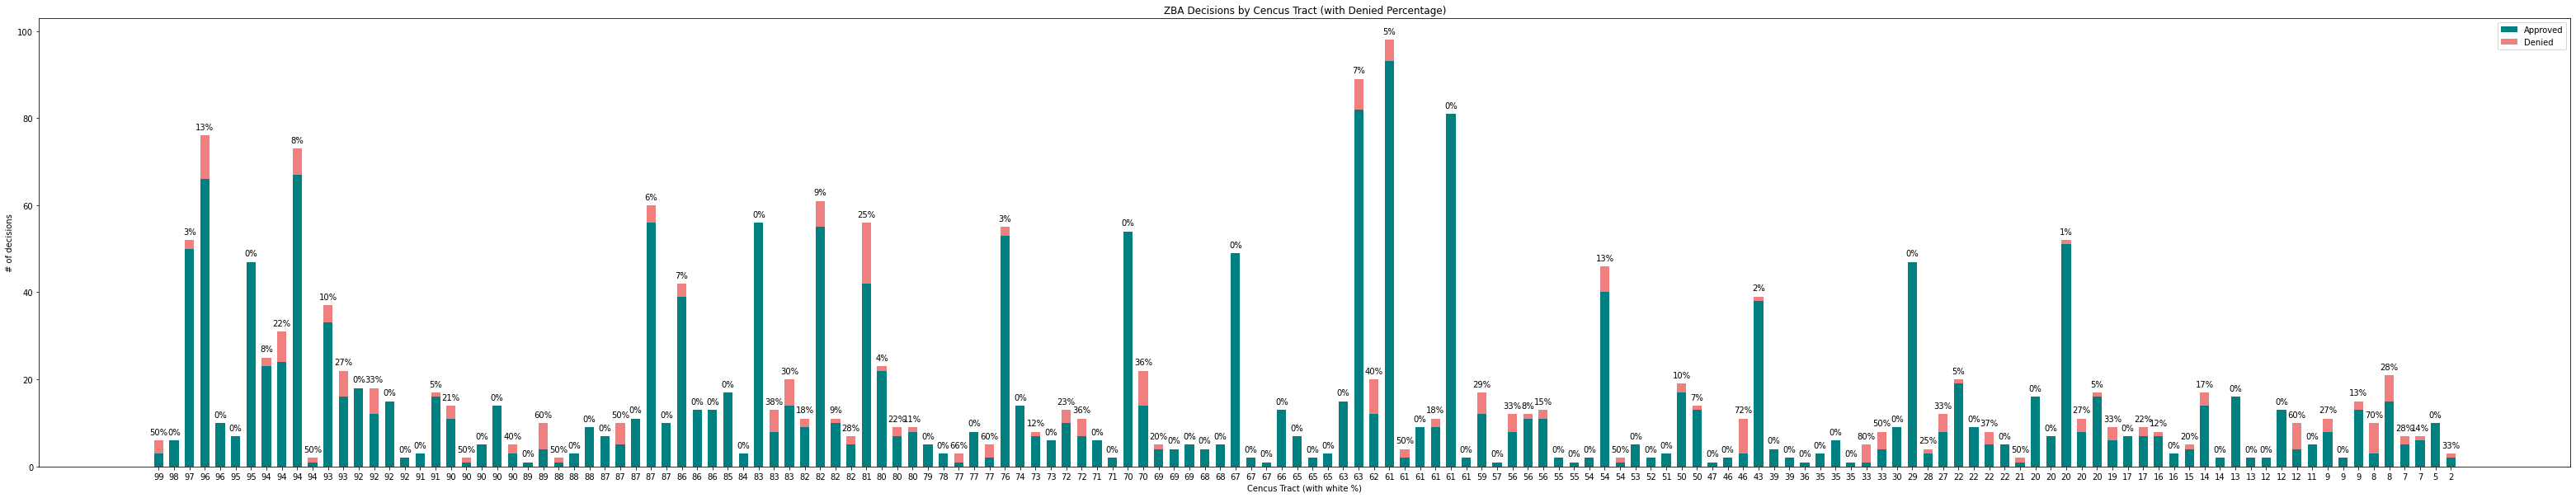

In [52]:
num_approved = grouped_ct_approved_size.values
num_denied = np.array(grouped_ct_stats['size'].values) - np.array(grouped_ct_approved_size.values)

title = "ZBA Decisions by Cencus Tract (with Denied Percentage)"
xlabel = "Cencus Tract (with white %)"
width = 0.6
grouped_stats = grouped_ct_stats

plt.figure(figsize=[55,10])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel("# of decisions")

ind = np.arange(len(grouped_stats))
p1 = plt.bar(ind, num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, num_denied, width, bottom=num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = [str(int(grouped_stats['mean'].values[i])) for i in range(len(grouped_stats['size'].index))]
plt.xticks(ind, xtix, rotation=0)

for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., grouped_stats['size'].values[i] + 1,
            '%d%%' % ((num_denied[i] / (num_denied[i] + num_approved[i])) * 100),
            ha='center', va='bottom')

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

Grouping by neighborhood and displaying zba decisions with denied vs approved sorted by white percentage

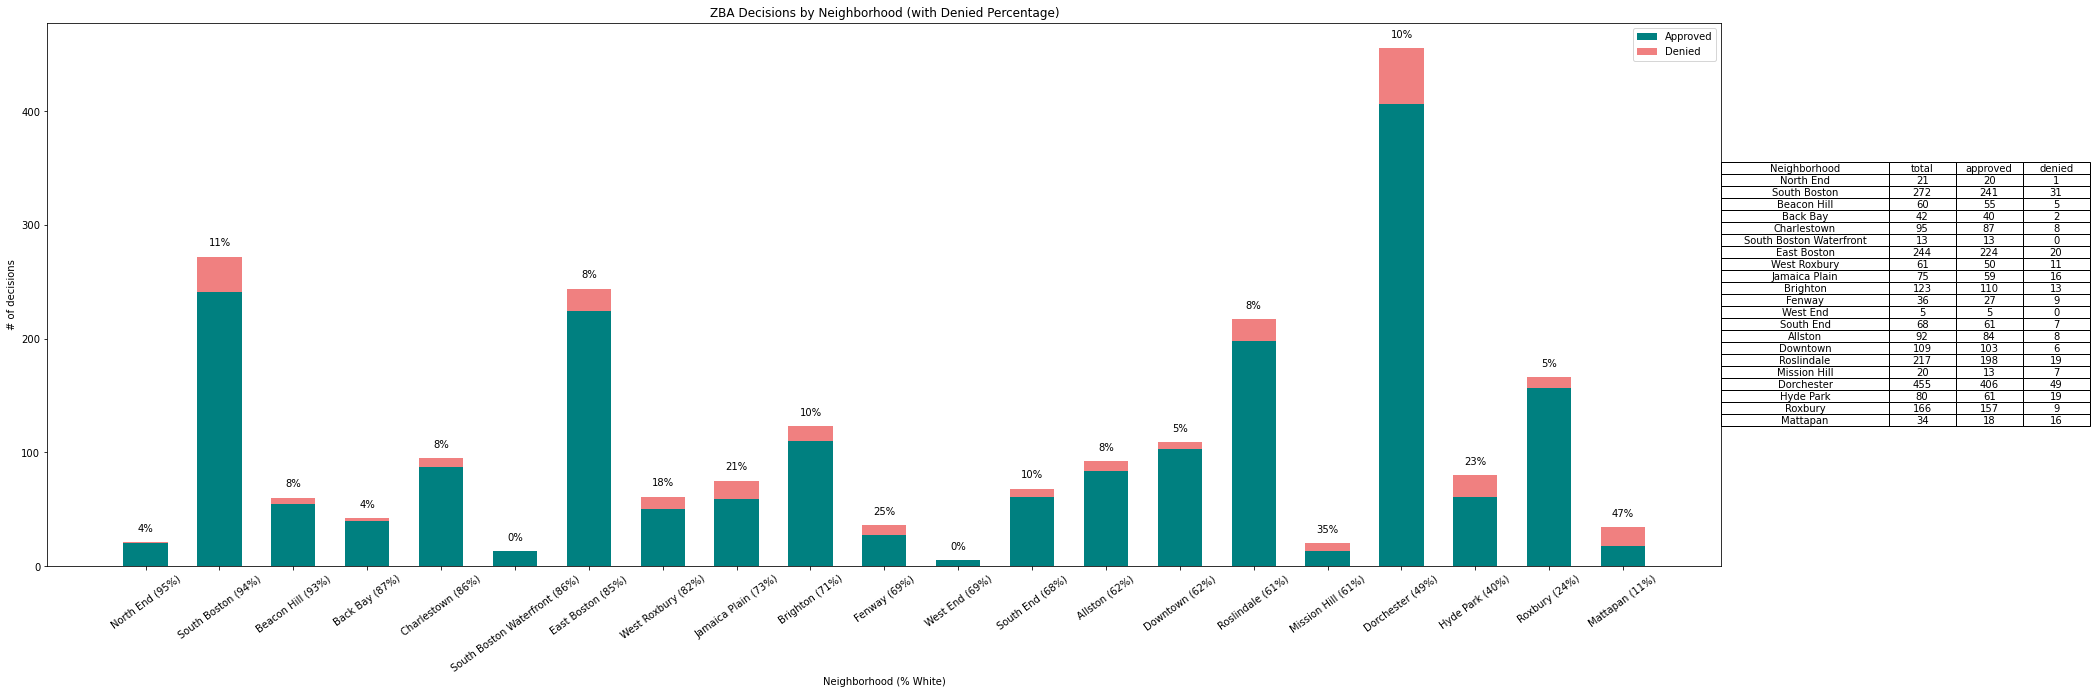

In [53]:
num_approved = grouped_neighs_approved_size.values
num_denied = np.array(grouped_neighs_stats['size'].values) - np.array(grouped_neighs_approved_size.values)

# plot the grouped data
title = "ZBA Decisions by Neighborhood (with Denied Percentage)"
xlabel = "Neighborhood (% White)"
width = 0.6
plt.figure(figsize=[30,10])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel("# of decisions")

ind = np.arange(len(grouped_neighs_stats))
p1 = plt.bar(ind, num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, num_denied, width, bottom=num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = [str(grouped_neighs_stats['size'].index[i]) + " (" + str(int(grouped_neighs_stats['mean'].values[i])) + "%)" for i in range(len(grouped_neighs_stats['size'].index))]
plt.xticks(ind, xtix, rotation=36)

# set up extra text in graph
for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., grouped_neighs_stats['size'].values[i] + 8,
            '%d%%' % ((num_denied[i] / (num_denied[i] + num_approved[i])) * 100),
            ha='center', va='bottom')

cell_data = [[neigh, tot, n_app, n_den] for neigh,tot,n_app,n_den in zip(grouped_neighs_stats.index, grouped_neighs_stats['size'].values, num_approved, num_denied)]
table = plt.table(cell_data, cellLoc='center', loc='right', colWidths=[0.1, 0.04, 0.04, 0.04], colLabels=['Neighborhood', 'total', 'approved', 'denied'])
table.auto_set_font_size(False)

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

Directly comparing West Roxbury to Roxbury

In [54]:
roxbury_stats = grouped_neighs_stats[(grouped_neighs_stats.index == 'Roxbury') | (grouped_neighs_stats.index == 'West Roxbury')]
rox_num_approved = num_approved[[7, 19]]
rox_num_denied = num_denied[[7, 19]]
roxbury_stats

,size,mean
Neighborhood,,
West Roxbury,61,82.084590
Roxbury,166,24.906024


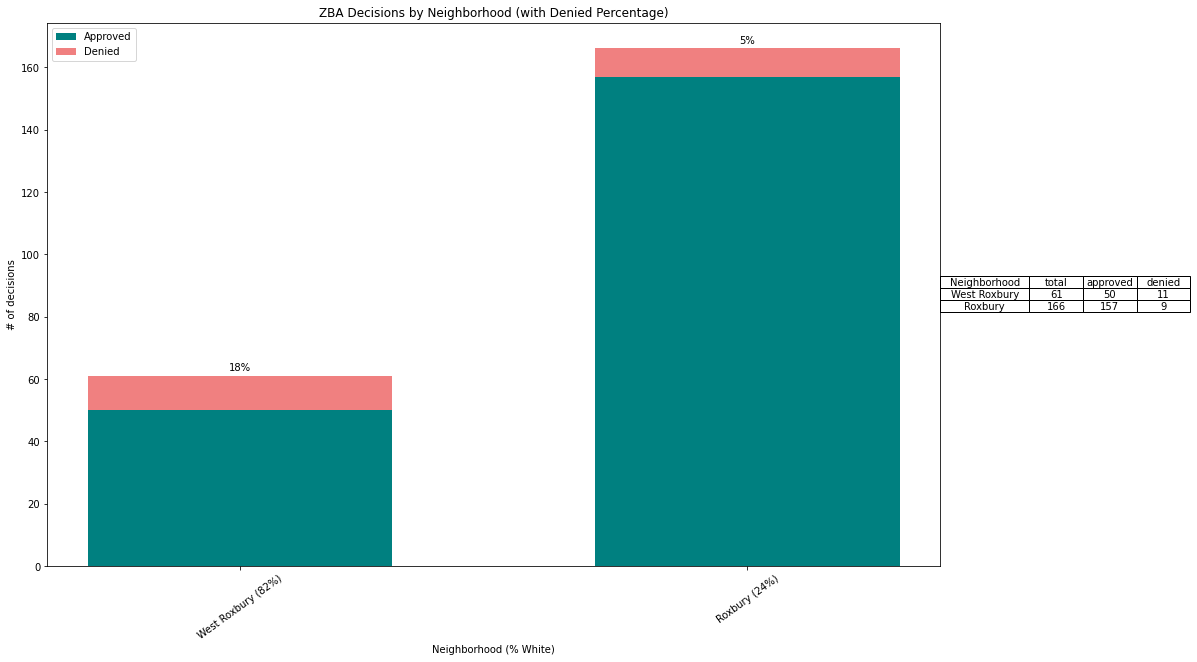

In [55]:
# plot the grouped data
title = "ZBA Decisions by Neighborhood (with Denied Percentage)"
xlabel = "Neighborhood (% White)"
width = 0.6
plt.figure(figsize=[16,10])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel("# of decisions")

ind = np.arange(len(roxbury_stats))
p1 = plt.bar(ind, rox_num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, rox_num_denied, width, bottom=rox_num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = [str(roxbury_stats['size'].index[i]) + " (" + str(int(roxbury_stats['mean'].values[i])) + "%)" for i in range(len(roxbury_stats['size'].index))]
plt.xticks(ind, xtix, rotation=36)

# set up extra text in graph
for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., roxbury_stats['size'].values[i] + 1,
            '%d%%' % ((rox_num_denied[i] / (rox_num_denied[i] + rox_num_approved[i])) * 100),
            ha='center', va='bottom')

cell_data = [[neigh, tot, n_app, n_den] for neigh,tot,n_app,n_den in zip(roxbury_stats.index, roxbury_stats['size'].values, rox_num_approved, rox_num_denied)]
table = plt.table(cell_data, cellLoc='center', loc='right', colWidths=[0.1, 0.06, 0.06, 0.06], colLabels=['Neighborhood', 'total', 'approved', 'denied'])
table.auto_set_font_size(False)

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

# Approved Building Permits Dataset

In [56]:
data_loaded = False
try:
    merged = pd.read_csv('data/approved_projects_with_demographics.csv')
    data_loaded = True
except:
    data_loaded = False

Set up necessary data structures

In [57]:
def prep_df_column(col, generate_map=False):
    """
    col: A pandas column-frame of strings
    generate_map: Whether or not to generate a map of the original values to the edited values 

    Outputs the columm with all the entries set to lowercase and with spaces removed
    """
    new_col = col.iloc[:, 0]
    new_col = [name.lower().replace(" ", "") for name in new_col]
    col_map = dict()
    if generate_map:
        for i in range(len(new_col)):
            col_map[new_col[i]] = col.iloc[:, 0][i]
        return new_col, col_map
    else:
        return new_col

In [58]:
data = pd.read_csv('data/abp_data.csv')

# separate into applicants and owners
df = data.loc[(data['permittypedescr'] == 'Erect/New Construction') | (data['permittypedescr'] == 'Excavation Permit') | (data['permittypedescr'] == 'Foundation Permit') | (data['description'] == 'Excavation Borings Test Pits') | (data['description'] == 'New construction') | (data['description'] == 'Erect')]
applicants = pd.DataFrame(df['applicant'])
owners = pd.DataFrame(df['owner'])

# preprocess
applicants.fillna("na")
applicants = applicants.applymap(str)
owners.fillna("na")
owners = owners.applymap(str)

# we split the encoders into two so they can keep track of their inverse transforms
applcants_encoder = LabelEncoder()
owners_encoder = LabelEncoder()

# here we also optionally output the mapping between the preprocessed values and the original, which we can use for display purposes
# however, building the map takes longer than we'd like

# applicants_cleaned, applicants_map = prep_df_column(applicants, generate_map=True)
# owners_cleaned, owners_map = prep_df_column(owners, generate_map=True)

applicants_cleaned = prep_df_column(applicants, generate_map=False)
applicants_labels = pd.DataFrame(applcants_encoder.fit_transform(applicants_cleaned))
applicants_labels_vals = applicants_labels.value_counts()
index = [tup[0] for tup in applicants_labels_vals.index]
applicants_labels_vals.index = applcants_encoder.inverse_transform(index)

owners_cleaned = prep_df_column(owners, generate_map=False)
owners_labels = pd.DataFrame(owners_encoder.fit_transform(owners_cleaned))
owners_labels_vals = owners_labels.value_counts()
owners_index = [tup[0] for tup in owners_labels_vals.index]
owners_labels_vals.index = owners_encoder.inverse_transform(owners_index)

sub_neigh = pd.read_csv("data/Sub-Neighborhoods.csv")
sub_neigh['Census Tract#'] = sub_neigh.apply(lambda row: float(row['Census Tract#']), axis=1)
sub_neigh['White Proportion'] = sub_neigh.apply(lambda row: float(row['White Proportion'][:-1]), axis=1)

In [59]:
def generate_approved_projects_with_demographics():
    df2 = df.copy()
    df2 = df2[df2['lat'].notna()]
    df2 = df2[df2['long'].notna()]
    df2['Cencus_Tract'] = df2.progress_apply(lambda row: float(Coord_to_census_tract(row.lat, row.long)), axis=1)

    merged = pd.merge(df2, sub_neigh, left_on="Cencus_Tract", right_on="Census Tract#")
    merged = merged.drop(columns=['Census Tract#', 'lat', 'long'])

    # write output to file
    merged.to_csv('data/approved_projects_with_demographics.csv')

    return merged

In [60]:
if not data_loaded:
    merged = generate_approved_projects_with_demographics()

## Analysis & Visualization

In [61]:
print("Percentage of neighborhoods with > 50% white population: \t\t    ", len(sub_neigh.loc[sub_neigh['White Proportion'] > 50.0].index)/len(sub_neigh.index))
print("Percentage of approved permits in neighborhoods with > 50% white population:", len(merged.loc[merged['White Proportion'] > 50.0].index)/len(merged.index))

Percentage of neighborhoods with > 50% white population: 		     0.6408839779005525
Percentage of approved permits in neighborhoods with > 50% white population: 0.7069473224997274


In [62]:
print("Percentage of neighborhoods with > 75% white population: \t\t    ", len(sub_neigh.loc[sub_neigh['White Proportion'] > 75.0].index)/len(sub_neigh.index))
print("Percentage of approved permits in neighborhoods with > 75% white population:", len(merged.loc[merged['White Proportion'] > 75.0].index)/len(merged.index))

Percentage of neighborhoods with > 75% white population: 		     0.3425414364640884
Percentage of approved permits in neighborhoods with > 75% white population: 0.44083324244737704


Visualization by companies of significance

In [63]:
owners = pd.DataFrame(merged['owner'])
owners = owners.applymap(str)
owners_cleaned = prep_df_column(owners, generate_map=False)
owners_labels = pd.DataFrame(owners_encoder.fit_transform(owners_cleaned))
owners_labels_vals = owners_labels.value_counts()
owners_index = [tup[0] for tup in owners_labels_vals.index]
owners_labels_vals.index = owners_encoder.inverse_transform(owners_index)

merged_majorityPOC = merged.loc[merged['White Proportion'] < 50.0]
owners_majorityPOC = pd.DataFrame(merged_majorityPOC['owner'])
owners_majorityPOC = owners_majorityPOC.applymap(str)
owners_cleaned_majorityPOC = prep_df_column(owners_majorityPOC, generate_map=False)
owners_labels_majorityPOC = pd.DataFrame(owners_encoder.fit_transform(owners_cleaned_majorityPOC))
owners_labels_vals_majorityPOC = owners_labels_majorityPOC.value_counts()
owners_index_majorityPOC = [tup[0] for tup in owners_labels_vals_majorityPOC.index]
owners_labels_vals_majorityPOC.index = owners_encoder.inverse_transform(owners_index_majorityPOC)

In [64]:
owners_amount = pd.DataFrame(owners_labels_vals)[2:]
owners_majorityPOC_amount = pd.DataFrame(owners_labels_vals_majorityPOC)[2:]
merged_amounts = owners_amount.merge(owners_majorityPOC_amount, left_index=True, right_index=True)
merged_amounts = merged_amounts.rename(columns={"0_x": "Total_Projects", "0_y": "POC_Community_Projects"})

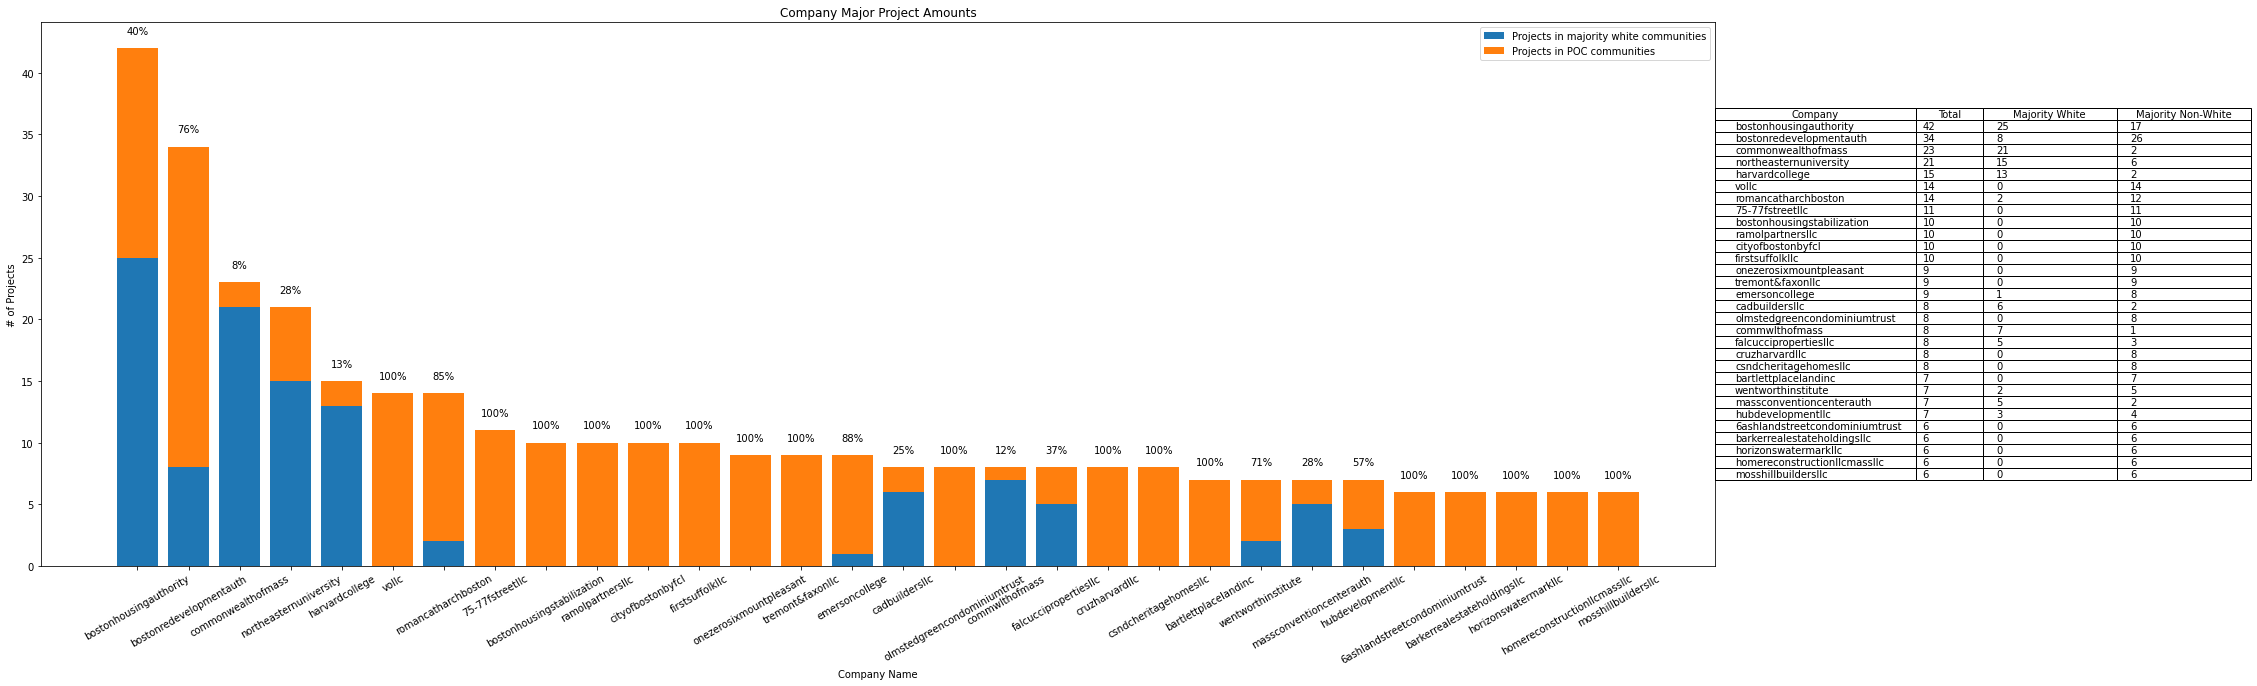

In [65]:
size = 30
num_projects_POC_community = merged_amounts["POC_Community_Projects"].values[:size]
num_projects_nonPOC_community = merged_amounts["Total_Projects"].values[:size] - merged_amounts["POC_Community_Projects"].values[:size]

plt.figure(figsize=[30, 10])
plt.title("Company Major Project Amounts")
plt.xlabel("Company Name")
plt.ylabel("# of Projects")

ind = np.arange(size)
p1 = plt.bar(ind, num_projects_nonPOC_community, label="Projects in majority white communities")
p2 = plt.bar(ind, num_projects_POC_community, label="Projects in POC communities", bottom=num_projects_nonPOC_community)

plt.legend()
xtix = [merged_amounts.index[i] for i in range(size)]
plt.xticks(ind, xtix, rotation = 30)

for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, merged_amounts["Total_Projects"][i] + 1, '%d%%' % ((num_projects_POC_community[i] / merged_amounts["Total_Projects"][i]) * 100), ha='center', va='bottom')

cell_data = [[neigh, tot, n_app, n_den] for neigh,tot,n_app,n_den in zip(merged_amounts["Total_Projects"].index[:size], merged_amounts["Total_Projects"].values[:size], num_projects_nonPOC_community, num_projects_POC_community)]
table = plt.table(cell_data, cellLoc='left', loc='right', colWidths=[0.12, 0.04, 0.08, 0.08], colLabels=['Company', 'Total', 'Majority White', 'Majority Non-White'])
table.auto_set_font_size(False)

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

Visualization by applicants of significance

In [66]:
applicants = pd.DataFrame(merged['applicant'])
applicants.fillna("na")
applicants = applicants.applymap(str)

applicants_cleaned = prep_df_column(applicants, generate_map=False)
applicants_cleaned = [x for x in applicants_cleaned if x != '' and not "cancelled" in x]


applicants_labels = pd.DataFrame(applcants_encoder.fit_transform(applicants_cleaned))

applicants_labels_vals = applicants_labels.value_counts()
index = [tup[0] for tup in applicants_labels_vals.index]
applicants_labels_vals.index = applcants_encoder.inverse_transform(index)

applicants_majorityPOC = pd.DataFrame(merged[merged['White Proportion'] < 50.0]['applicant'])
applicants_majorityPOC.fillna("na")
applicants_majorityPOC = applicants_majorityPOC.applymap(str)

applicants_majorityPOC_cleaned = prep_df_column(applicants_majorityPOC, generate_map=False)
applicants_majorityPOC_cleaned = [x for x in applicants_majorityPOC_cleaned if x != '' and not "cancelled" in x]


applicants_majorityPOC_labels = pd.DataFrame(applcants_encoder.fit_transform(applicants_majorityPOC_cleaned))

applicants_majorityPOC_labels_vals = applicants_majorityPOC_labels.value_counts()
index = [tup[0] for tup in applicants_majorityPOC_labels_vals.index]
applicants_majorityPOC_labels_vals.index = applcants_encoder.inverse_transform(index)

applicant_amount = pd.DataFrame(applicants_labels_vals)[1:]
applicant_majorityPOC_amount = pd.DataFrame(applicants_majorityPOC_labels_vals)[1:]
merged_amounts_applicant = applicant_majorityPOC_amount.merge(applicant_amount, left_index=True, right_index=True)
merged_amounts_applicant = merged_amounts_applicant.rename(columns={"0_x": "POC_Community_Projects", "0_y": "Total_Projects"})

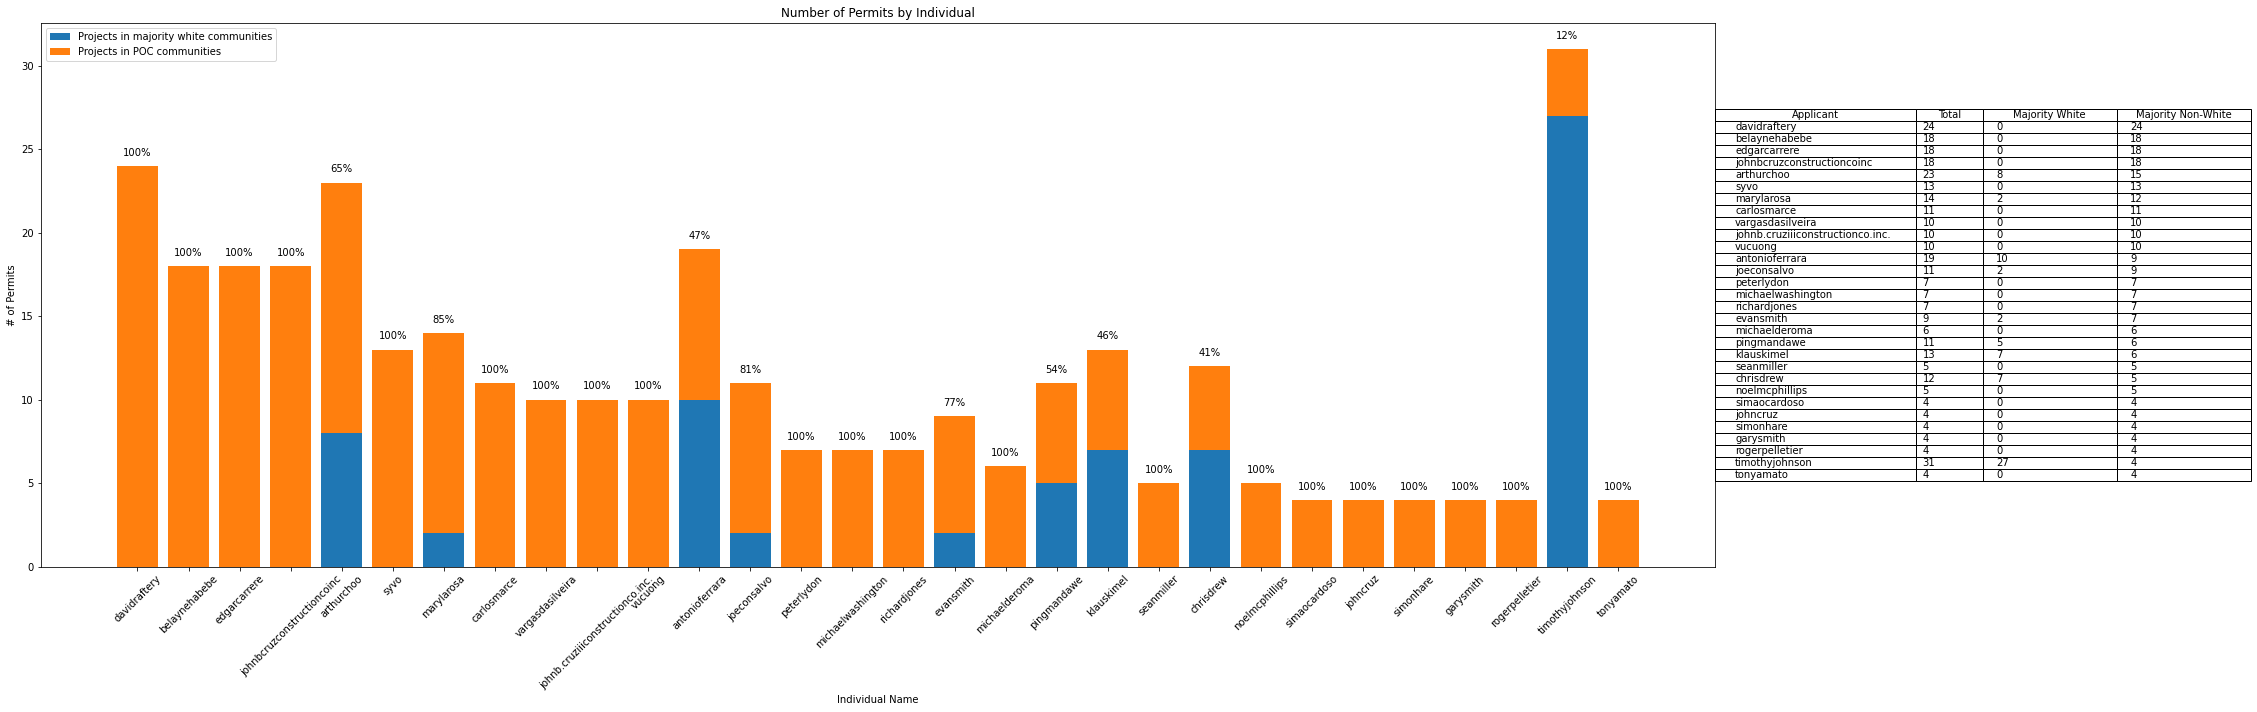

In [67]:
size = 30
num_projects_POC_community = merged_amounts_applicant["POC_Community_Projects"].values[:size]
num_projects_nonPOC_community = merged_amounts_applicant["Total_Projects"].values[:size] - merged_amounts_applicant["POC_Community_Projects"].values[:size]

plt.figure(figsize=[30, 10])
plt.title("Number of Permits by Individual")
plt.xlabel("Individual Name")
plt.ylabel("# of Permits")

ind = np.arange(size)
p1 = plt.bar(ind, num_projects_nonPOC_community, label="Projects in majority white communities")
p2 = plt.bar(ind, num_projects_POC_community, label="Projects in POC communities", bottom=num_projects_nonPOC_community)

plt.legend()
xtix = [merged_amounts_applicant.index[i] for i in range(size)]
plt.xticks(ind, xtix, rotation = 45)

for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, merged_amounts_applicant["Total_Projects"][i] + 0.5, '%d%%' % ((num_projects_POC_community[i] / merged_amounts_applicant["Total_Projects"][i]) * 100), ha='center', va='bottom')

cell_data = [[neigh, tot, n_app, n_den] for neigh,tot,n_app,n_den in zip(merged_amounts_applicant["Total_Projects"].index[:size], merged_amounts_applicant["Total_Projects"].values[:size], num_projects_nonPOC_community, num_projects_POC_community)]
table = plt.table(cell_data, cellLoc='left', loc='right', colWidths=[0.12, 0.04, 0.08, 0.08], colLabels=['Applicant', 'Total', 'Majority White', 'Majority Non-White'])
table.auto_set_font_size(False)

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

### Refering back to ZBA approval/denial dataset

Individuals' approval/denial rates

In [68]:
def clean_names(row):
    name = row['Applicant']
    name = str(name)
    name = name.replace(" ", "")
    name = name.replace("\n", "")
    name = name.split(",")[0]
    name = name.lower()
    row['Applicant'] = name
    return row

grouped_apps = decisions_with_demos.progress_apply(clean_names, axis=1).groupby('Applicant')
grouped_apps_stats = grouped_apps.agg("size").sort_values(ascending=False)
grouped_apps_approved_stats = decisions_with_demos.progress_apply(clean_names, axis=1)[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'].groupby('Applicant').agg("size").sort_values(ascending=False)

merged = pd.DataFrame(grouped_apps_stats).merge(pd.DataFrame(grouped_apps_approved_stats), left_index=True, right_index=True)
grouped_apps_all_stats = merged.rename(columns={'0_x': 'total', '0_y': 'approved'})
grouped_apps_all_stats['denied'] = grouped_apps_all_stats['total'] - grouped_apps_all_stats['approved']

100%|██████████| 2288/2288 [00:00<00:00, 11701.28it/s]


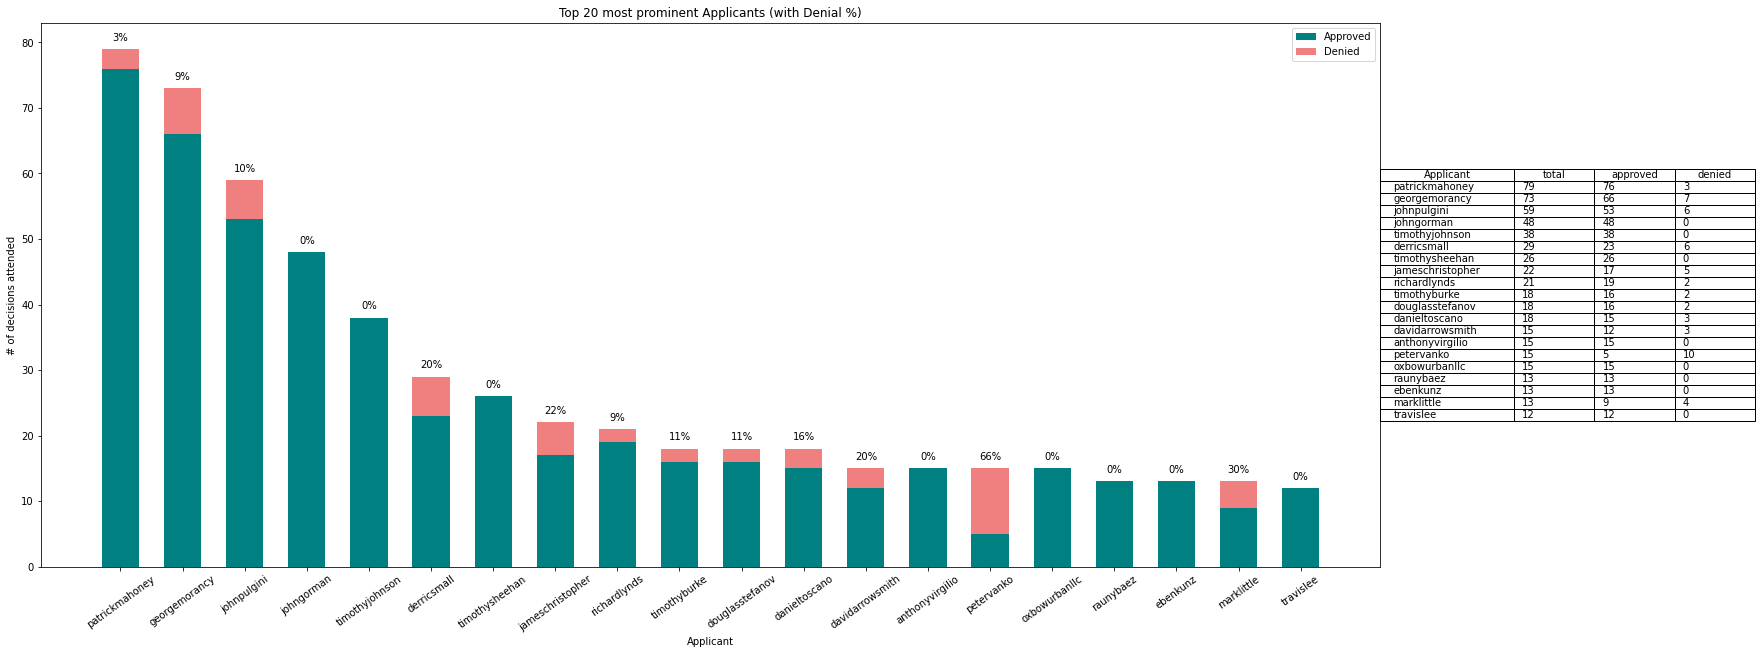

In [69]:
grouped_apps_all_stats = grouped_apps_all_stats[:20] # get top 20 most prominent
apps_num_approved = grouped_apps_all_stats['approved'].values
apps_num_denied = grouped_apps_all_stats['denied'].values

# plot
plt.figure(figsize=[24,10])
plt.title("Top 20 most prominent Applicants (with Denial %)")
plt.xlabel("Applicant")
plt.ylabel("# of decisions attended")

ind = np.arange(len(grouped_apps_all_stats))
p1 = plt.bar(ind, apps_num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, apps_num_denied, width, bottom=apps_num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = grouped_apps_all_stats.index
plt.xticks(ind, xtix, rotation=36)

for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., grouped_apps_all_stats['total'][i] + 1,
            '%d%%' % ((apps_num_denied[i] / (apps_num_denied[i] + apps_num_approved[i])) * 100),
            ha='center', va='bottom')

cell_data = [[neigh, tot, n_app, n_den] for neigh,tot,n_app,n_den in zip(grouped_apps_all_stats.index, grouped_apps_all_stats['total'].values, apps_num_approved, apps_num_denied)]
table = plt.table(cell_data, cellLoc='left', loc='right', colWidths=[0.1, 0.06, 0.06, 0.06], colLabels=['Applicant', 'total', 'approved', 'denied'])
table.auto_set_font_size(False)

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

Individuals' approval/denial rates in majority non-white areas

In [70]:
decisions_with_demos_poc = decisions_with_demos[decisions_with_demos['White Proportion'] < 50.0]
grouped_apps_poc = decisions_with_demos_poc.progress_apply(clean_names, axis=1).groupby('Applicant')
grouped_apps_poc_stats = grouped_apps_poc.agg("size").sort_values(ascending=False)
grouped_apps_poc_approved_stats = decisions_with_demos_poc.progress_apply(clean_names, axis=1)[decisions_with_demos_poc['Decision (Approve/Reject)'] == 'Approved'].groupby('Applicant').agg("size").sort_values(ascending=False)

merged = pd.DataFrame(grouped_apps_poc_stats).merge(pd.DataFrame(grouped_apps_poc_approved_stats), left_index=True, right_index=True)
grouped_apps_poc_all_stats = merged.rename(columns={'0_x': 'total', '0_y': 'approved'})
grouped_apps_poc_all_stats['denied'] = grouped_apps_poc_all_stats['total'] - grouped_apps_poc_all_stats['approved']

100%|██████████| 496/496 [00:00<00:00, 16259.79it/s]


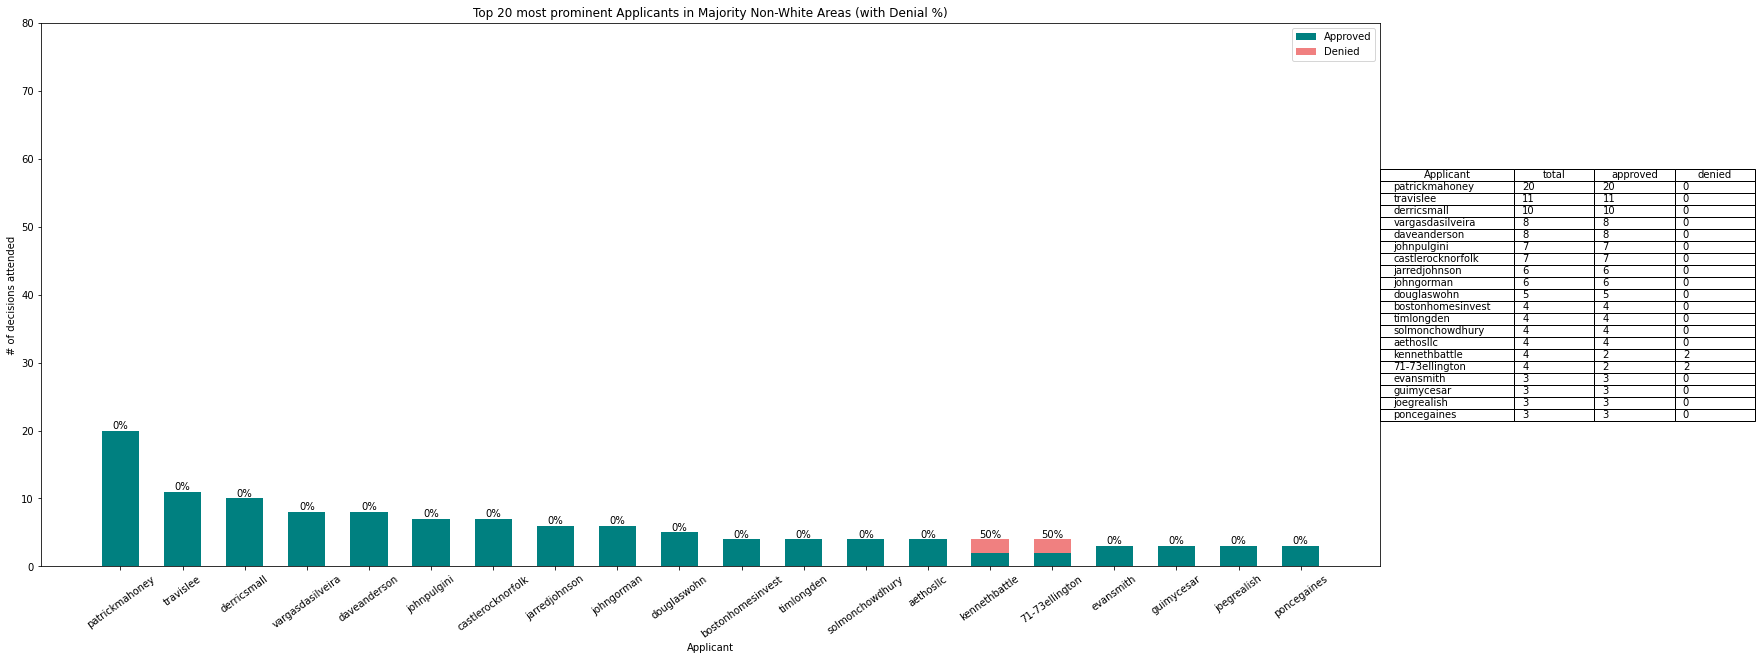

In [71]:
grouped_apps_poc_all_stats = grouped_apps_poc_all_stats[:20]
apps_num_approved = grouped_apps_poc_all_stats['approved'].values
apps_num_denied = grouped_apps_poc_all_stats['denied'].values

# plot the data
plt.figure(figsize=[24,10])
plt.title("Top 20 most prominent Applicants in Majority Non-White Areas (with Denial %)")
plt.xlabel("Applicant")
plt.ylabel("# of decisions attended")
plt.gca().set_ylim([0, 80])

ind = np.arange(len(grouped_apps_poc_all_stats))
p1 = plt.bar(ind, apps_num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, apps_num_denied, width, bottom=apps_num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = grouped_apps_poc_all_stats.index
plt.xticks(ind, xtix, rotation=36)

for i in range(len(p1)):
    rect = p1[i]
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., grouped_apps_poc_all_stats['total'][i],
            '%d%%' % ((apps_num_denied[i] / (apps_num_denied[i] + apps_num_approved[i])) * 100),
            ha='center', va='bottom')
            
cell_data = [[neigh, tot, n_app, n_den] for neigh,tot,n_app,n_den in zip(grouped_apps_poc_all_stats.index, grouped_apps_poc_all_stats['total'].values, apps_num_approved, apps_num_denied)]
table = plt.table(cell_data, cellLoc='left', loc='right', colWidths=[0.1, 0.06, 0.06, 0.06], colLabels=['Applicant', 'total', 'approved', 'denied'])
table.auto_set_font_size(False)

pdf.savefig(bbox_inches="tight", dpi=300)
chart_num += 1
plt.savefig(fname='charts/chart'+str(chart_num)+'.png', bbox_inches="tight", dpi=300)
plt.show()

In [72]:
pdf.close()